In [2]:
import os
import sys

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Flatten, Dense, Reshape, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

# modify sys.path for it to contain the main repo path so we can import modules such as below
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from utils.helper import get_root_dir, set_seed, setup_gpu
from utils.data import load_data_with_test_split
from utils.plots import plot_reconstructions, plot_history
from utils.latent_space import plot_latent_space
from utils.evaluation import evaluate_autoencoder, ssim_loss, ssim_l1_loss, dssim_loss, evaluate_autoencoder_with_threshold_generator

In [3]:
# Hyperparameter to tune
config = {
    "comment" : "test wandb",
    "epochs" : 1,
    "loss" : 'mse',
    "optimizer" : "adam",
    "dropout": True,
    "dropout_value" : 0.0,
    "rotation_range" : 90,
    "batch_size" : 16,
    "latent_dim" : 512,
    "threshold_percentage" : 80,
    "data_class" : "screw",
    "model_type" : "autoencoder"
}

# Rather static parameters, no need to track
IMAGE_SIZE = (256, 256)
INPUT_SHAPE = IMAGE_SIZE + (3,)

In [4]:
wandb.init(project="autoencoder", config=config)
config = wandb.config # this turns our hyperparameter config into a proper object with attributes
wandb.define_metric('val_loss', summary='min')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: hendrik-spl (itu-aml-project). Use `wandb login --relogin` to force relogin


In [5]:
root_dir = get_root_dir()
# root_dir = 'Mini Project'

set_seed(1234)

model_dir = os.path.join(root_dir, 'models', config.model_type)

cpkt_path = os.path.join(model_dir, 'logs', 'checkpoints', f'{config.comment}_checkpoint.model.keras')
weights_path = os.path.join(model_dir, 'logs', 'weights', f'{config.comment}_model.keras')
assert not os.path.exists(weights_path), f'Path already exists: {weights_path}. Please change the comment.'

In [6]:
train_generator, validation_generator, test_generator, threshold_generator = load_data_with_test_split(
    category="screw",
    batch_size=32,
    test_split=0.4,
    rotation_range=config.rotation_range
)

Found 256 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
Found 98 images belonging to 6 classes.
Found 62 images belonging to 6 classes.


In [7]:
def vanilla_autoencoder(input_shape=INPUT_SHAPE, optimizer='', latent_dim=512, loss='mse'):
    """
        input_shape (tuple): Shape of the input images (height, width, channels).
        latent_dim (int): Dimension of the latent space.
        loss (str): Loss used to train the autoencoder. Options: 'mse', 'ssim', etc.
    """
    # Encoder
    input_img = Input(shape=input_shape)

    # Encoder with reduced complexity
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # (128, 128, 32)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # (64, 64, 64)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # (32, 32, 128)
    x = Dropout(0.3)(x)

    # Bottleneck
    x = Flatten()(x)  # Flattened Shape: (32 * 32 * 128,)
    encoded = Dense(latent_dim)(x)  # Latent space size reduced to 526
    encoded = BatchNormalization()(encoded)
    encoded = LeakyReLU(name='bottleneck')(encoded)

    # Decoder with reduced complexity
    x = Dense(32 * 32 * 128)(encoded)
    x = Reshape((32, 32, 128))(x)

    x = UpSampling2D((2, 2))(x)  # (64, 64, 128)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2))(x)  # (128, 128, 64)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2))(x)  # (256, 256, 32)
    x = Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder Model
    autoencoder = Model(input_img, x)
    autoencoder.compile(optimizer=optimizer, loss=loss)
    return autoencoder

# get correct loss from config as functions are not callable from config itself
if config.loss == 'mae': loss = 'mae'
elif config.loss == 'mse': loss = 'mse'
elif config.loss == 'dssim_loss': loss = dssim_loss
elif config.loss == 'ssim_loss': loss = ssim_loss
elif config.loss == 'ssim_l1_loss': loss = ssim_l1_loss
else:
    raise ValueError(f"Unknown loss function: {config.loss}. Please define a function to calculate the error.")

print(f"Used Loss to train:{loss}")
print(f"Optimizer: {config.optimizer}")

autoencoder = vanilla_autoencoder(
    input_shape=INPUT_SHAPE, 
    optimizer=config.optimizer, 
    latent_dim=config.latent_dim, 
    loss=loss
)

print("Input shape:", autoencoder.input_shape)
print("Output shape:", autoencoder.output_shape)

# autoencoder.summary()

# Log the architecture config
model_config = autoencoder.get_config()
wandb.config.update({"autoencoder_architecture": model_config})

Used Loss to train:mse
Optimizer: adam
Input shape: (None, 256, 256, 3)
Output shape: (None, 256, 256, 3)


In [12]:
#define early stopping and checkpoints
early_stop = EarlyStopping(
    monitor="val_loss", 
    mode="min",
    patience=20, 
    start_from_epoch=20
    )

history = autoencoder.fit(
    train_generator,
    epochs=config.epochs,
    validation_data=validation_generator,
    callbacks=[
        early_stop,
        WandbMetricsLogger(),
        WandbModelCheckpoint(f"models/checkpoints/{config.comment}.keras", verbose=1, save_best_only=True), # Saves model checkpoint to W&B
    ],
)

wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.
/Users/hendriksippel/Documents/Repositories/itu-aml-anomaly-detection/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - loss: 0.0924 
Epoch 1: val_loss improved from inf to 0.03931, saving model to models/checkpoints/test wandb.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 116s 14s/step - loss: 0.0891 - val_loss: 0.0393


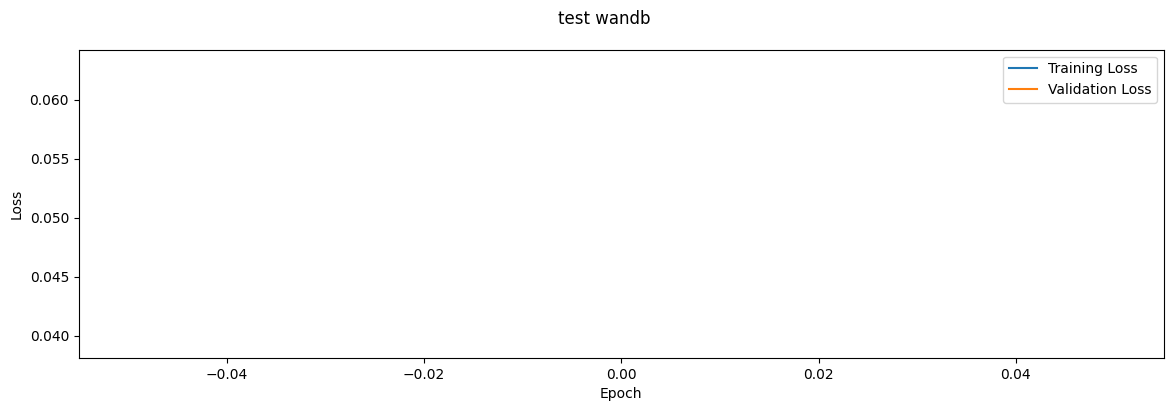

Best train_loss: 0.063
Best val_loss: 0.0393
Last improvement of val_loss at epoch: 1


In [13]:
# plot the training history
plot_history(comment=config.comment, history=history, wandb=wandb)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


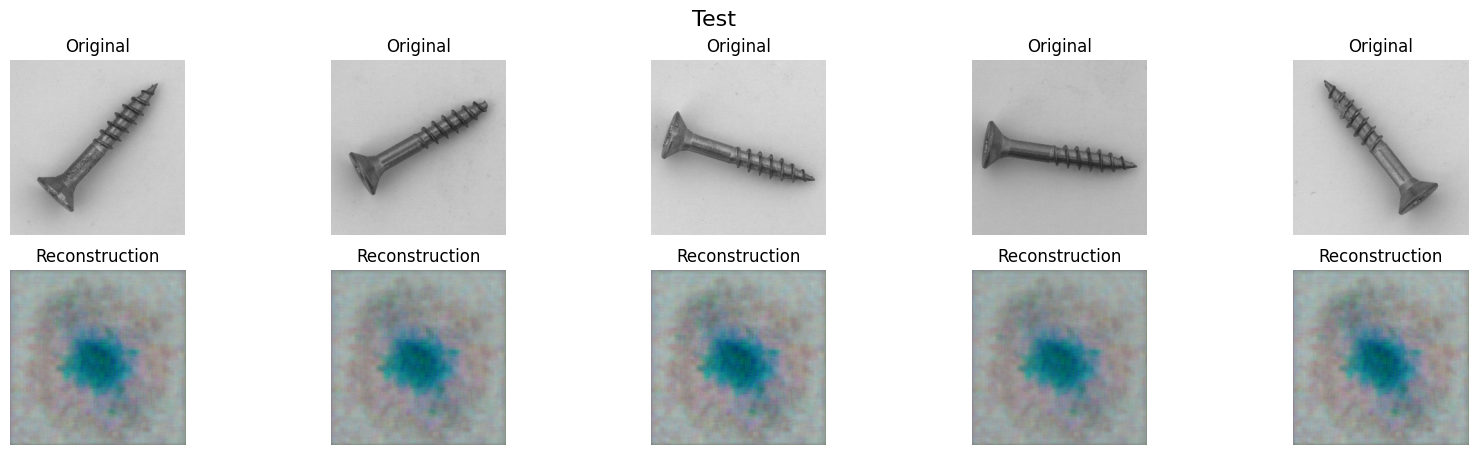

In [14]:
plot_reconstructions(autoencoder, test_generator, n_images=5, title='Test', wandb=wandb)

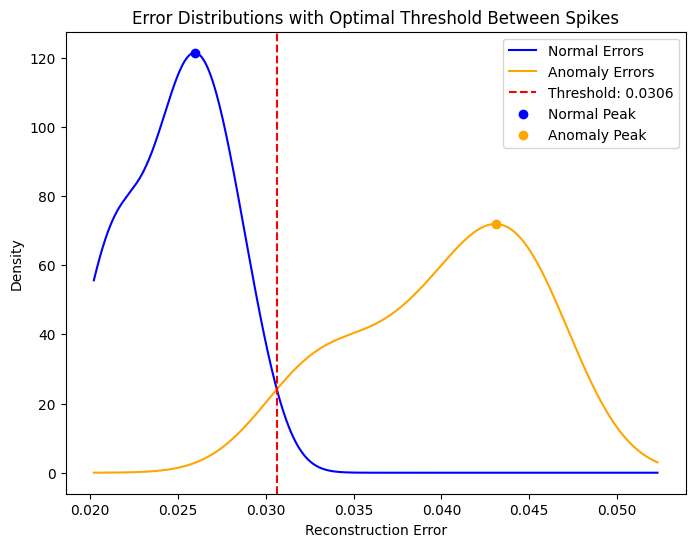

Optimal Threshold: 0.0306
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        26
     Anomaly       1.00      1.00      1.00        72

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98



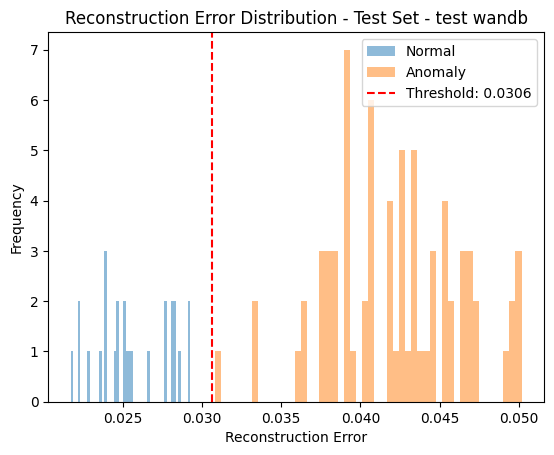

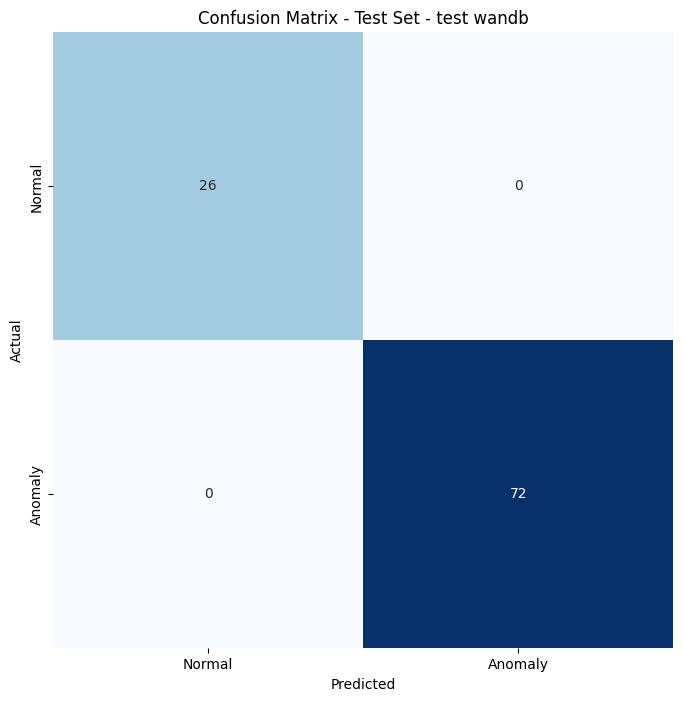

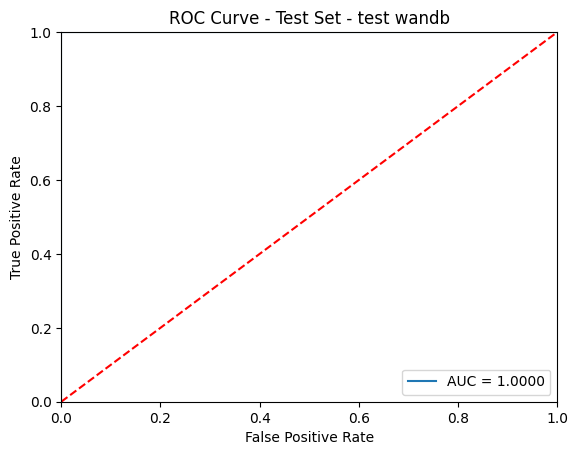

In [18]:
import importlib
import utils.evaluation

importlib.reload(utils.evaluation)
from utils.evaluation import evaluate_autoencoder_with_threshold_generator

# sampling generated from flow
evaluate_autoencoder_with_threshold_generator(
    autoencoder=autoencoder,
    test_generator=test_generator,
    threshold_generator=threshold_generator,
    config=config,
    wandb=wandb
)

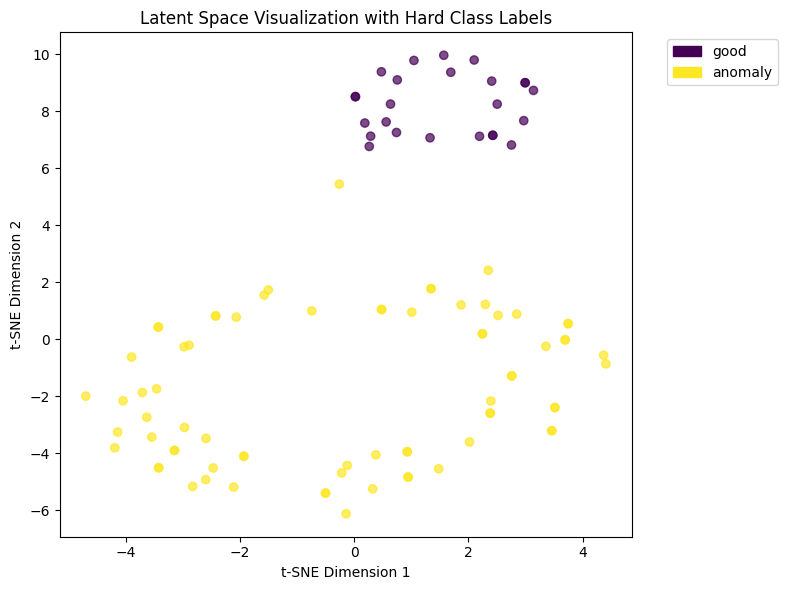

In [22]:
plot_latent_space(autoencoder, test_generator, wandb, layer_name='bottleneck')

In [27]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

def preprocess_image(image_path, target_size=(256, 256)):
    """Load and preprocess an image for the autoencoder."""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0  # Normalize to [0, 1] and set to float32
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def calculate_reconstruction_error(original, reconstructed):
    """Calculate the mean squared error between original and reconstructed images."""
    return np.mean((original - reconstructed) ** 2)

def predict_anomaly_and_plot(autoencoder, image_path, mask_dir, threshold=0.02):
    """
    Predict if an image is an anomaly based on reconstruction error
    and plot original, reconstructed, and mask images.
    
    Parameters:
        autoencoder (Model): The trained autoencoder model.
        image_path (str): Path to the image file.
        mask_dir (str): Directory containing anomaly mask images.
        threshold (float): Error threshold to classify as anomaly.
    
    Returns:
        bool: True if anomaly, False otherwise.
        float: The reconstruction error.
    """
    # Preprocess the image
    img = preprocess_image(image_path)
    
    # Reconstruct the image with the autoencoder
    reconstructed_img = autoencoder.predict(img)

    # Ensure reconstructed image is in float32 format
    reconstructed_img = reconstructed_img.astype('float32')
    
    # Calculate reconstruction error
    error = calculate_reconstruction_error(img, reconstructed_img)
    
    # Classify as anomaly if error exceeds the threshold
    is_anomaly = error > threshold

    # Generate the corresponding mask path
    file_name = os.path.basename(image_path).split('.')[0] + '_mask.png'
    label = os.path.basename(os.path.dirname(image_path))
    mask_path = os.path.join(mask_dir, label, file_name)
    
    # Load the mask image if it exists
    if os.path.exists(mask_path):
        mask_img = plt.imread(mask_path)
    else:
        mask_img = None

    # Plot original, reconstructed, and mask images
    plt.figure(figsize=(12, 4))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img[0])  # Remove batch dimension for display
    plt.title("Original Image")
    plt.axis("off")
    
    # Reconstructed image
    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_img[0])  # Remove batch dimension for display
    plt.title("Reconstructed Image")
    plt.axis("off")
    
    # Anomaly mask
    plt.subplot(1, 3, 3)
    if mask_img is not None:
        plt.imshow(mask_img, cmap="gray")
        plt.title("Anomaly Mask")
    else:
        plt.text(0.5, 0.5, 'No Mask Available', ha='center', va='center', fontsize=12)
    plt.axis("off")
    
    plt.suptitle(f"Reconstruction Error: {error:.4f}| Threshold: {threshold} | Anomaly: {'Yes' if is_anomaly else 'No'}")
    plt.show()
    
    return is_anomaly, error

# Example usage
# Example usage
"""mask_dir = '../../data/screw/ground_truth'
image_paths = [
    '../../data/screw/test/manipulated_front/001.png',
    '../../data/screw/test/scratch_head/001.png', 
    '../../data/screw/test/scratch_neck/001.png' 
]"""
mask_dir = 'data/screw/ground_truth'
image_paths = [
    'data/screw/test/manipulated_front/001.png',
    'data/screw/test/scratch_head/001.png', 
    'data/screw/test/scratch_neck/001.png' 
]
for path in image_paths: 
    is_anomaly, error = predict_anomaly_and_plot(autoencoder, path, mask_dir)


[ WARN:0@930.736] global loadsave.cpp:241 findDecoder imread_('data/screw/test/manipulated_front/001.png'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [24]:
wandb.finish()